In [1]:
# Notebook to compare linear models with linear models based on nonlinear features


import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(42)
np.random.seed(42) 

import pickle
from jax import jacfwd
import jax.numpy as jnp
import copy
# Import interact function from ipywidgets
from ipywidgets import interact, fixed
# Import float slider from ipywidgets
from ipywidgets import FloatSlider, IntSlider, widgets

import src.featlin
from src.featlin import Featlin
from src.featlin import jax_moment
from src.helper import optimize_cv

import src.basis as basis
from src.basis import BasicsData

plt.style.use('./styles/plots.mplstyle')

%load_ext autoreload
%autoreload 2

In [2]:
# Whether to generate data or load it from file
# Load it from file to reproduce results from the paper
# Otherwise, random noise will be different, leading to different results
generate_data = 0

# Setting this variable to 1 will save the generated data to file
# And overwrite the data in the folder 
save_generated_data = 0

In [3]:
# Load the LFP Dataset
lfp_df = pd.read_csv('./data/lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])
X_lfp = X_lfp[:, ::-1]
y_lfp_true = np.array(lfp_df.iloc[:, 1000])
x_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_lfp_train_true = np.log10(np.array(y_lfp_true[lfp_df.iloc[:, 1002]==0]))
X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
y_lfp_test_true = np.log10(np.array(y_lfp_true[lfp_df.iloc[:, 1002]==1]))
X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
y_lfp_test2_true = np.log10(np.array(y_lfp_true[lfp_df.iloc[:, 1002]==2]))

labels_lfp = {'xdata_label': 'Voltage (V)', 'ydata_label': r'$\Delta \mathbf{Q}_{100\mathrm{-}10}$ (Ah)', 'row_label': 'Battery number'}

stdX = np.std(X_lfp_train, axis=0)
meanX = np.mean(X_lfp_train, axis=0)
meany = np.mean(y_lfp_train_true)

In [4]:
# Remove the two nasty outliers
# Otherwise the model accurcay will be very biased. 

# Remove outlier Training
id_outlier = np.where(np.mean(X_lfp_train, axis=1)==np.min(np.mean(X_lfp_train, axis=1)))
X_lfp_train = np.delete(X_lfp_train, id_outlier, axis=0)
y_lfp_train_true = np.delete(y_lfp_train_true, id_outlier, axis=0)

# Remove outlier Test
id_outlier = np.where(np.mean(X_lfp_test, axis=1)==np.min(np.mean(X_lfp_test, axis=1)))
X_lfp_test = np.delete(X_lfp_test, id_outlier, axis=0)
y_lfp_test_true = np.delete(y_lfp_test_true, id_outlier, axis=0)


# The FeatDH toolkit curernlty does not support data beyond the trainign data. 
# Therefore the necessary functions are adapted slightly and copied here.

def construct_y_data(X, targetfun, per_range: list=None):
    """Construct responsese for a given target function
    """
    if per_range is None:
        per_range = [0, 1]

    columns = X.shape[1]
    low_ind = int(per_range[0]*columns)
    high_ind = int(per_range[1]*columns)
    # self.y = targetfun(self.X[:, low_ind:high_ind])

    rows = X.shape[0]
    y = np.zeros([rows])
    for i in range(rows):
        row_i = X[i, :]
        y[i] = targetfun(row_i[low_ind:high_ind])
    return y


In [16]:
# Putting all data in a dictionary
X_dict = {
    'train': X_lfp_train, 'test': X_lfp_test, 'test2': X_lfp_test2, 'x': x_lfp, 
    'train_': X_lfp_train-meanX, 'test_': X_lfp_test-meanX, 'test2_': X_lfp_test2-meanX,
    'train_std_': (X_lfp_train-meanX)/stdX, 'test_std_': (X_lfp_test-meanX)/stdX, 'test2_std_': (X_lfp_test2-meanX)/stdX,
    'mean': meanX, 'std': stdX}

y_dict = {
    'train_cl': y_lfp_train_true, 'test_cl': y_lfp_test_true, 'test2_cl': y_lfp_test2_true,
    'train_cl_': y_lfp_train_true-meany, 'test_cl_': y_lfp_test_true-meany, 'test2_cl_': y_lfp_test2_true-meany,
    'mean': meany}

# Fit the two models that have features and raw data
# TOdo compare with second ourtlier removed as well.
variance = np.append(100*np.var(X_dict['train'], axis=1).reshape(-1, 1), np.sum(X_dict['train']**2, axis=1).reshape(-1, 1))
variance_test = np.append(100*np.var(X_dict['test'], axis=1).reshape(-1, 1), np.sum(X_dict['test']**2, axis=1).reshape(-1, 1))
variance_test2 = np.append(100*np.var(X_dict['test2'], axis=1).reshape(-1, 1), np.sum(X_dict['test2']**2, axis=1).reshape(-1, 1))

# Rescale variace to be between min and max of X
#variance = (variance-np.min(variance)) #/(np.max(X_dict['train'])-np.min(X_dict['train']))
#variance_test = (variance_test-np.min(variance_test))#/(np.max(X_dict['test'])-np.min(X_dict['test']))
#variance_test2 = (variance_test2-np.min(variance_test2))#/(np.max(X_dict['test2'])-np.min(X_dict['test2']))

# append the variance to the X matrix
X_dict['train_feat'] = np.append(variance, X_dict['train'], axis=1)
X_dict['test_feat'] = np.append(variance_test.reshape(-1, 1), X_dict['test'], axis=1)
X_dict['test2_feat'] = np.append(variance_test2.reshape(-1, 1), X_dict['test2'], axis=1)
X_dict['train_feat_'] = X_dict['train_feat']-np.mean(X_dict['train_feat'], axis=0)
X_dict['test_feat_'] = X_dict['test_feat']-np.mean(X_dict['train_feat'], axis=0)
X_dict['test2_feat_'] = X_dict['test2_feat']-np.mean(X_dict['train_feat'], axis=0)
X_dict['train_feat_std_'] = X_dict['train_feat_']/np.std(X_dict['train_feat_'], axis=0)
X_dict['test_feat_std_'] = X_dict['test_feat_']/np.std(X_dict['train_feat_'], axis=0)
X_dict['test2_feat_std_'] = X_dict['test2_feat_']/np.std(X_dict['train_feat_'], axis=0)

AxisError: axis 1 is out of bounds for array of dimension 1

In [21]:
# append two vectors alonmg a new axis 

TypeError: _append_dispatcher() got an unexpected keyword argument 'newaxis'

In [6]:
# Run crossvalidation to estimate parameters.
# 4 runs, two per model (std and non std dat)
# Compare predictions where y is the cycle life

res_dict_rr_cl = optimize_cv(X_dict['train_'], y_dict['train_cl_'], max_comps=20, alpha_lim=[10e-7, 10e3], folds=20, nb_stds=1, 
        plot_components=False, std=False, min_distance_search=False, 
        featlin=None, algorithm='RR', plot=False)

res_dict_pls_cl = optimize_cv(X_dict['train_'], y_dict['train_cl_'], max_comps=20, alpha_lim=[10e-5, 10e3], folds=20, nb_stds=1, 
        plot_components=False, std=False, min_distance_search=False, 
        featlin=None, algorithm='PLS', plot=False)

res_dict_pls_cl_feat = optimize_cv(X_dict['train_feat_'], y_dict['train_cl_'], max_comps=20, alpha_lim=[10e-7, 10e3], folds=20, nb_stds=1, 
        plot_components=False, std=False, min_distance_search=False, 
        featlin=None, algorithm='PLS', plot=False)

res_dict_pls_cl_feat_std = optimize_cv(X_dict['train_feat_'], y_dict['train_cl_'], max_comps=20, alpha_lim=[10e-5, 10e3], folds=20, nb_stds=1, 
        plot_components=False, std=False, min_distance_search=False, 
        featlin=None, algorithm='PLS', plot=False)


res_dict_rr_cl_std = optimize_cv(X_dict['train_std_'], y_dict['train_cl_'], max_comps=20, alpha_lim=[10e-1, 10e2], folds=20, nb_stds=1, 
        plot_components=False, std=False, min_distance_search=False, 
        featlin=None, algorithm='RR', plot=False)

res_dict_pls_cl_std = optimize_cv(X_dict['train_std_'], y_dict['train_cl_'], max_comps=20, alpha_lim=[10e-1, 10e2], folds=20, nb_stds=1, 
        plot_components=False, std=False, min_distance_search=False, 
        featlin=None, algorithm='PLS', plot=False)


In [7]:
print('PLS CV opt Feat: ' + str(res_dict_pls_cl_feat['cv_res']['rmse_min_param']))
print('PLS CV1sig Feat: ' + str(res_dict_pls_cl_feat['cv_res']['rmse_std_min_param']))
print('PLS CV opt std Feat: ' + str(res_dict_pls_cl_feat_std['cv_res']['rmse_min_param']))
print('PLS CV1sig std Feat: ' + str(res_dict_pls_cl_feat_std['cv_res']['rmse_std_min_param']))

print('PLS CV opt: ' + str(res_dict_pls_cl['cv_res']['rmse_min_param']))
print('PLS CV1sig: ' + str(res_dict_pls_cl['cv_res']['rmse_std_min_param']))
print('PLS CV opt std: ' + str(res_dict_pls_cl_std['cv_res']['rmse_min_param']))
print('PLS CV1sig std: ' + str(res_dict_pls_cl_std['cv_res']['rmse_std_min_param']))

print('RR CV opt: ' + str(res_dict_rr_cl['cv_res']['rmse_min_param']))
print('RR CV1sig: ' + str(res_dict_rr_cl['cv_res']['rmse_std_min_param']))
print('RR CV1 opt std: ' + str(res_dict_rr_cl_std['cv_res']['rmse_min_param']))
print('RR CV1sig std: ' + str(res_dict_rr_cl_std['cv_res']['rmse_std_min_param']))

PLS CV opt Feat: 8
PLS CV1sig Feat: 2
PLS CV opt std Feat: 8
PLS CV1sig std Feat: 2
PLS CV opt: 8
PLS CV1sig: 2
PLS CV opt std: 9
PLS CV1sig std: 3
RR CV opt: 5.1794746792312125e-05
RR CV1sig: 0.00019306977288832515
RR CV1 opt std: 3.9810717055349722
RR CV1sig std: 19.306977288832496


In [8]:
# Putting all models in a dictionary
# Scale and intercept are set to false becasue I prefer to do it manually
# This list is a bit long, but it is easier to keep track of the models this way for this comparison.
models = {
    #'PLS_sums_cv': PLSRegression(n_components=1, scale=False),
    #'PLS_sums_cv1sig': PLSRegression(n_components=1, scale=False),
    #'PLS_sums_cv_std': PLSRegression(n_components=1, scale=False),
    #'PLS_sums_cv1sig_std': PLSRegression(n_components=1, scale=False),
    #'RR_sums_cv': Ridge(alpha=1.0, fit_intercept=False),
    #'RR_sums_cv1sig': Ridge(alpha=1.0, fit_intercept=False),
    #'RR_sums_cv_std': Ridge(alpha=1.0, fit_intercept=False),
    #'RR_sums_cv1sig_std': Ridge(alpha=1.0, fit_intercept=False),
    'PLS_cl_feat_cv': PLSRegression(n_components=res_dict_pls_cl_feat['cv_res']['rmse_min_param'], scale=False),
    'PLS_cl_feat_cv1sig': PLSRegression(n_components=res_dict_pls_cl_feat['cv_res']['rmse_std_min_param'], scale=False),
    'PLS_cl_feat_cv_std': PLSRegression(n_components=res_dict_pls_cl_feat_std['cv_res']['rmse_min_param'], scale=False),
    'PLS_cl_feat_cv1sig_std': PLSRegression(n_components=res_dict_pls_cl_feat_std['cv_res']['rmse_std_min_param'], scale=False),
    'PLS_cl_cv': PLSRegression(n_components=res_dict_pls_cl['cv_res']['rmse_min_param'], scale=False),
    'PLS_cl_cv1sig': PLSRegression(n_components=res_dict_pls_cl['cv_res']['rmse_std_min_param'], scale=False),
    'PLS_cl_cv_std': PLSRegression(n_components=res_dict_pls_cl_std['cv_res']['rmse_min_param'], scale=False),
    'PLS_cl_cv1sig_std': PLSRegression(n_components=res_dict_pls_cl_std['cv_res']['rmse_std_min_param'], scale=False),
    'RR_cl_cv': Ridge(alpha=res_dict_rr_cl['cv_res']['rmse_min_param'], fit_intercept=False),
    'RR_cl_cv1sig': Ridge(alpha=res_dict_rr_cl['cv_res']['rmse_std_min_param'], fit_intercept=False),
    'RR_cl_cv_std': Ridge(alpha=res_dict_rr_cl_std['cv_res']['rmse_min_param'], fit_intercept=False),
    'RR_cl_cv1sig_std': Ridge(alpha=res_dict_rr_cl_std['cv_res']['rmse_std_min_param'], fit_intercept=False)}


# Making a pd dataframe to store the results
results = pd.DataFrame(index=models.keys(), columns=['Model', 'X', 'y', 'NRMSE Training', 'NRMSE Test', 'NRMSE Test 2', 'RMSE Training', 'RMSE Test', 'RMSE Test 2'])

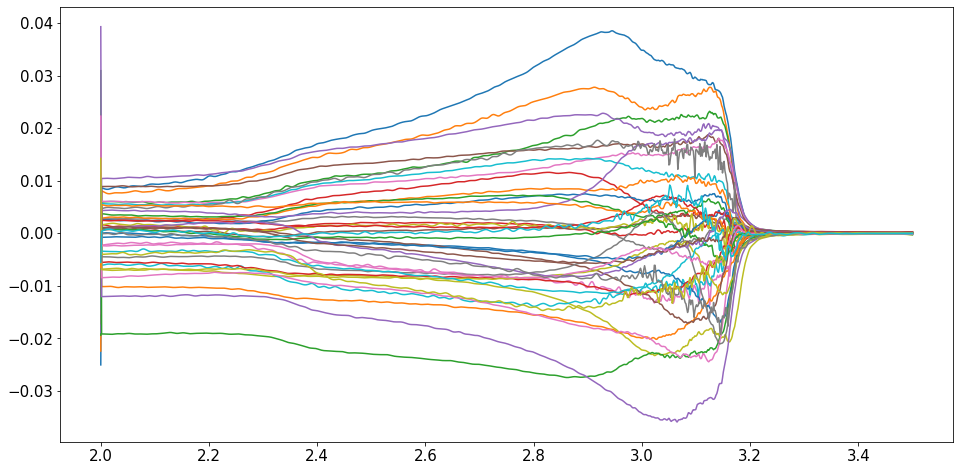

In [9]:
plt.plot(np.linspace(2.0, 3.5, 1001), X_dict['train_feat_'].T)
plt.show()

In [10]:
# Fit all models that only depend on the raw data

for key in models.keys():
    if 'feat' in key:
        if key.endswith('std'):
            print('Feat std')
            X_ = X_dict['train_feat_std_']
            X_test_ = X_dict['test_feat_std_']
            X_test2_ = X_dict['test2_feat_std_']
            X_tag = 'X, variace appended, Z-scored'
        else:
            print('Feat')
            X_ = X_dict['train_feat_']
            X_test_ = X_dict['test_feat_']
            X_test2_ = X_dict['test2_feat_']
            X_tag = 'X, variace appended'
    else:
        if key.endswith('std'):
            X_ = X_dict['train_std_']
            X_test_ = X_dict['test_std_']
            X_test2_ = X_dict['test2_std_']
            X_tag = 'Z-scored'
        else:
            X_ = X_dict['train_']
            X_test_ = X_dict['test_']
            X_test2_ = X_dict['test2_']
            X_tag = 'Mean-centered'
    if 'sums' in key:
        y_ = y_dict['train_sums_']
        y_test_ = y_dict['test_sums_']
        y_test2_ = y_dict['test2_sums_']
        y_tag = 'Sum of Squares'
    elif 'cl' in key:
        y_ = y_dict['train_cl_']
        y_test_ = y_dict['test_cl_']
        y_test2_ = y_dict['test2_cl_']
        y = y_dict['train_cl']
        y_test = y_dict['test_cl']
        y_test2 = y_dict['test2_cl']
        y_tag = 'Cylce Life'
    
    # Fit the model
    models[key].fit(X_, y_)

    # Predict the training data
    y_pred = models[key].predict(X_)+y_dict['mean']
    y_test_pred = models[key].predict(X_test_)+y_dict['mean']
    y_test2_pred = models[key].predict(X_test2_)+y_dict['mean']

    # Calculate the MSE
    mse_train = mean_squared_error(10**y, 10**y_pred, squared=False)
    mse_test = mean_squared_error(10**y_test, 10**y_test_pred, squared=False)
    mse_test2 = mean_squared_error(10**y_test2, 10**y_test2_pred, squared=False)

    # Calculate the NRMSE
    # I am using the std of the training data to calculate the NRMSE    
    nrmse_train = mean_squared_error(10**y, 10**y_pred, squared=False)/(np.max(10**y_)-np.min(10**y_))
    nrmse_test = mean_squared_error(10**y_test, 10**y_test_pred, squared=False)/(np.max(10**y_)-np.min(10**y_))
    nrmse_test2 = mean_squared_error(10**y_test2, 10**y_test2_pred, squared=False)/(np.max(10**y_)-np.min(10**y_))
    
    # Store the results
    results.loc[key, 'Model'] = ''
    results.loc[key, 'X'] = X_tag
    results.loc[key, 'y'] = y_tag
    results.loc[key, 'NRMSE Training'] = nrmse_train
    results.loc[key, 'NRMSE Test'] = nrmse_test
    results.loc[key, 'NRMSE Test 2'] = nrmse_test2
    results.loc[key, 'RMSE Training'] = mse_train
    results.loc[key, 'RMSE Test'] = mse_test
    results.loc[key, 'RMSE Test 2'] = mse_test2

Feat
Feat
Feat std
Feat std


In [11]:
results.iloc[:8, :]

,Model,X,y,NRMSE Training,NRMSE Test,NRMSE Test 2,RMSE Training,RMSE Test,RMSE Test 2
PLS_cl_feat_cv,,"X, variace appended",Cylce Life,19.354757,42.486162,72.081291,53.84122,118.188351,200.516321
PLS_cl_feat_cv1sig,,"X, variace appended",Cylce Life,40.392278,51.90306,74.489253,112.363565,144.384354,207.214809
PLS_cl_feat_cv_std,,"X, variace appended, Z-scored",Cylce Life,19.498651,35.172474,61.968662,54.241504,97.843073,172.384926
PLS_cl_feat_cv1sig_std,,"X, variace appended, Z-scored",Cylce Life,66.439,85.1295,117.700575,184.82055,236.813934,327.420414
PLS_cl_cv,,Mean-centered,Cylce Life,20.652646,43.20421,73.622346,57.451698,120.185821,204.803239
PLS_cl_cv1sig,,Mean-centered,Cylce Life,40.528588,52.119704,74.497061,112.742754,144.987015,207.23653
PLS_cl_cv_std,,Z-scored,Cylce Life,20.896503,37.86944,62.326461,58.130062,105.345516,173.380257
PLS_cl_cv1sig_std,,Z-scored,Cylce Life,43.105093,60.977871,77.890805,119.910099,169.628737,216.677274


In [12]:
results

,Model,X,y,NRMSE Training,NRMSE Test,NRMSE Test 2,RMSE Training,RMSE Test,RMSE Test 2
PLS_cl_feat_cv,,"X, variace appended",Cylce Life,19.354757,42.486162,72.081291,53.84122,118.188351,200.516321
PLS_cl_feat_cv1sig,,"X, variace appended",Cylce Life,40.392278,51.90306,74.489253,112.363565,144.384354,207.214809
PLS_cl_feat_cv_std,,"X, variace appended, Z-scored",Cylce Life,19.498651,35.172474,61.968662,54.241504,97.843073,172.384926
PLS_cl_feat_cv1sig_std,,"X, variace appended, Z-scored",Cylce Life,66.439,85.1295,117.700575,184.82055,236.813934,327.420414
PLS_cl_cv,,Mean-centered,Cylce Life,20.652646,43.20421,73.622346,57.451698,120.185821,204.803239
PLS_cl_cv1sig,,Mean-centered,Cylce Life,40.528588,52.119704,74.497061,112.742754,144.987015,207.23653
PLS_cl_cv_std,,Z-scored,Cylce Life,20.896503,37.86944,62.326461,58.130062,105.345516,173.380257
PLS_cl_cv1sig_std,,Z-scored,Cylce Life,43.105093,60.977871,77.890805,119.910099,169.628737,216.677274
RR_cl_cv,,Mean-centered,Cylce Life,20.138596,42.596986,71.642009,56.021711,118.496642,199.294323
RR_cl_cv1sig,,Mean-centered,Cylce Life,25.567592,41.801447,70.321157,71.124136,116.283605,195.619964


In [13]:
# TODO: Check the results, and decite what to put in the resulting latex table

# TODO: Make a latex table with the results dataframe